In [36]:
include("model.jl")
include("Parser.jl")
include("greedy.jl")
include("utils.jl")
using JuMP

## Data processing

In [37]:
n, m, x_VC, y_VC, x_loc, y_loc, Q, C, q, f, p, tc, B, R, localities_with_high_priorities, M = parse_instance("./Instances/coord20-5-1_processed.dat")

(20, 5, [6.0, 19.0, 37.0, 35.0, 5.0], [7.0, 44.0, 23.0, 6.0, 8.0], [20.0, 8.0, 29.0, 18.0, 19.0, 31.0, 38.0, 33.0, 2.0, 1.0, 26.0, 20.0, 15.0, 20.0, 17.0, 15.0, 5.0, 13.0, 38.0, 9.0], [35.0, 31.0, 43.0, 39.0, 47.0, 24.0, 50.0, 21.0, 27.0, 12.0, 20.0, 33.0, 46.0, 26.0, 19.0, 12.0, 30.0, 40.0, 5.0, 40.0], 70, [140, 140, 140, 140, 140], [17, 18, 13, 19, 12, 18, 13, 13, 17, 20, 16, 18, 15, 11, 18, 16, 15, 15, 15, 16], [10841, 11961, 6091, 7570, 7497], 1000, 0, 15549.245317275838, [13.958791596349233, 12.114607178090317, 9.951277348331352, 12.467724566948226, 14.326988158440654], [12, 5, 15], 5)

In [48]:
println("Budget: ", B)
println("Q = ", Q)
println("C = ", C)

Budget: 15549.245317275838
Q = 70
C = [140, 140, 140, 140, 140]


In [39]:
# Create the distance matrix
distance_matrix = zeros(Float64, m, n)

for i in 1:m 
    for j in 1:n
        distance_matrix[i, j] = sqrt((x_VC[i] - x_loc[j])^2 + (y_VC[i] - y_loc[j])^2)
    end
end


# Create reachability matrix a
A = zeros(Int, m, n)


for i in 1:m
    for j in 1:n
        if distance_matrix[i, j] <= R[i]
            A[i, j] = 1
        end
    end
end

In [40]:
D = zeros(Float64, n+m, n+m)
#The n first rows/cols of D relate to the localities, the m last to the VC
#In other words, calling D[i,j] for i in I, j in J corresponds to call D[i+n,j]
for i in 1:m+n
    for j in 1:m+n
        if i <= n && j <= n
            # Both indices in `loc`
            D[i, j] = sqrt((x_loc[i] - x_loc[j])^2 + (y_loc[i] - y_loc[j])^2)
        elseif i > n && j > n
            # Both indices in `VC`
            D[i, j] = sqrt((x_VC[i - n] - x_VC[j - n])^2 + (y_VC[i - n] - y_VC[j - n])^2)
        elseif i > n && j <= n
            # i in `VC`, j in `loc`
            D[i, j] = sqrt((x_VC[i - n] - x_loc[j])^2 + (y_VC[i - n] - y_loc[j])^2)
        else
            # i in `loc`, j in `VC`
            D[i, j] = sqrt((x_loc[i] - x_VC[j - n])^2 + (y_loc[i] - y_VC[j - n])^2)
        end
    end
end

## Greedy Algorithm

In [41]:
MMTs, Budget, Q_MMTs, Q_tot = greedy_OptVax(n, m, D, A, Q, C, q, f, p, B, R, localities_with_high_priorities, M)

([[(22, 22), (22, 15), (15, 16), (16, 10), (10, 22)], [(22, 22), (22, 9), (9, 17), (17, 2), (2, 14), (14, 22)], [(22, 22), (22, 11), (11, 22)]], 15010.041630560343, [54, 61, 16], 131)

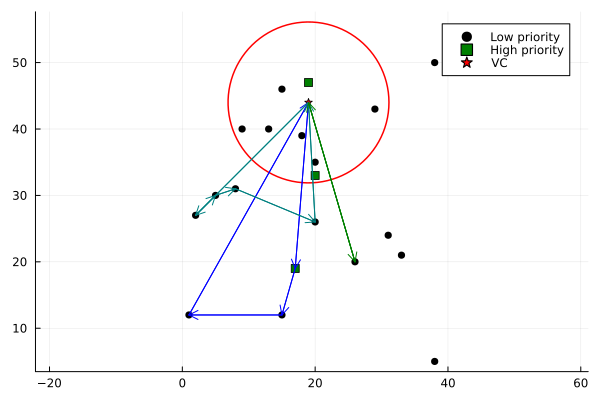

In [42]:
plot_solution_greedy(MMTs, x_VC, y_VC, x_loc, y_loc, R, n, m, M, localities_with_high_priorities)

## Models Creation

### OptVax1

In [43]:
# model_OptVax1 = solve_OptVax1(n, m, D, A, Q, C, q, f, p, B, R, localities_with_high_priorities, M)

# obj_val = objective_value(model_OptVax1)
# println("Objective Value: ", obj_val)

### OptVax2

In [44]:
# model_OptVax2 = solve_OptVax2(n, m, D, A, Q, C, q, f, p, B, R, localities_with_high_priorities, M)
# obj_val = objective_value(model_OptVax2)
# println("Objective Value: ", obj_val)

### OptVax2LP

In [45]:
# model_OptVax2LP = solve_OptVax2LP(n, m, D, A, Q, C, q, f, p, B, R, localities_with_high_priorities, M)
# obj_val = objective_value(model_OptVax2LP)
# println("Objective Value: ", obj_val)

In [46]:
# plot_solution(model_OptVax1, x_VC, y_VC, x_loc, y_loc, R,n,m,M, localities_with_high_priorities)